In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import tensorflow_datasets as tfds

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

# from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

import pdb
import copy

In [2]:
with open('/kaggle/input/shak-new-input/train.txt', 'r', encoding='utf-8') as f:
    text_train = f.read()
    
with open('/kaggle/input/shak-new-input/test.txt', 'r', encoding='utf-8') as f:
    text_validation = f.read()    

In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text_train+text_validation)))
# chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
train_data = jnp.array(encode(text_train), dtype=jnp.int32)
test_data = jnp.array(encode(text_validation), dtype=jnp.int32)
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [6]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [7]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
seq_size = block_size

num_layers = 2

max_iters = 50000
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
mamba_n_embd = 64
expans = 2
emb_features = mamba_n_embd * expans
s6_n_embd = mamba_n_embd * expans
n_filters = 4
n_conv = 3
hidden_dim = (2**(n_conv-1))*s6_n_embd*n_filters
conv_k_size = 3
n_latent_dim = 16
n_tokens = 1

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + block_size, (1,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
(64, 32)
[[43 52 58 ... 58 53 53]
 [43 52  6 ... 57  1 56]
 [46 63  1 ... 58  1 57]
 ...
 [53 59 57 ... 46  1 44]
 [ 1 56 53 ... 51  1 42]
 [ 0 28 13 ... 50 53 56]]
targets:
(64, 1)
[[ 1]
 [43]
 [58]
 [ 1]
 [60]
 [58]
 [57]
 [ 1]
 [53]
 [59]
 [ 1]
 [63]
 [41]
 [42]
 [57]
 [45]
 [41]
 [39]
 [39]
 [53]
 [53]
 [46]
 [56]
 [21]
 [57]
 [ 1]
 [46]
 [43]
 [43]
 [ 1]
 [56]
 [30]
 [47]
 [43]
 [ 0]
 [53]
 [ 0]
 [58]
 [44]
 [57]
 [57]
 [43]
 [39]
 [58]
 [42]
 [43]
 [58]
 [43]
 [ 1]
 [ 1]
 [41]
 [42]
 [ 1]
 [47]
 [39]
 [51]
 [43]
 [39]
 [13]
 [58]
 [47]
 [47]
 [56]
 [42]]


In [8]:
print(xb[0])
print(yb[0])

[43 52 58 43 56 58 39 47 52 51 43 52 58  0 35 47 58 46  1 41 46 39 56 39
 41 58 43 56  1 58 53 53]
[1]


In [9]:
# sdffsdfsdf

In [10]:
class Down_Conv(nn.Module):
    features: int = 256
    kernel_size: int = 2
    padding: str = 'CAUSAL'
    
    @nn.compact
    def __call__(self, x):
        
        conv1 = jax.nn.silu(nn.Conv(features=self.features, kernel_size=self.kernel_size, padding=self.padding)(x))
        max_pool1 = nn.max_pool(conv1 , window_shape=(self.kernel_size,), strides=(1,), padding='same')
#         max_pool1_ind = (conv1 == jnp.repeat(max_pool1 , repeats=2, axis=1)).astype(jnp.int32)
        #########################################################################################################
        conv2 = jax.nn.silu(nn.Conv(features=self.features*2, kernel_size=self.kernel_size, padding=self.padding)(max_pool1))
        max_pool2 = nn.max_pool(conv2 , window_shape=(self.kernel_size,), strides=(1,), padding='same')
#         max_pool2_ind = (conv2 == jnp.repeat(max_pool2 , repeats=2, axis=1)).astype(jnp.int32)   
        #########################################################################################################
        conv3 = jax.nn.silu(nn.Conv(features=self.features*4, kernel_size=self.kernel_size, padding=self.padding)(max_pool2))
        max_pool3 = nn.max_pool(conv3 , window_shape=(self.kernel_size,), strides=(1,), padding='same')
#         max_pool3_ind = (conv3 == jnp.repeat(max_pool3 , repeats=2, axis=1)).astype(jnp.int32)
        ######################################################################################################### 

#         pdb.set_trace()
        return max_pool3
    

In [11]:
class Up_Conv(nn.Module):
    
    @nn.compact
    def __call__(self, x):
    
        #########################################################################################################
#         uconv3 = jnp.repeat(x, repeats=2, axis=1)*jnp.concatenate([max_pool3_ind[:,1:,:],jnp.ones((max_pool3_ind.shape[0],1,max_pool3_ind.shape[-1]))], axis=1)
#         cat_conv3 = jnp.concatenate([conv3, uconv3], axis=-1)
#         conv4 = jax.nn.silu(nn.Conv(features=cat_conv3.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv3))
        conv3T = nn.ConvTranspose(x.shape[-1]//2, kernel_size = 3, padding = 1)(x)
        #########################################################################################################
#         uconv2 = jnp.repeat(conv3T, repeats=2, axis=1)*jnp.concatenate([max_pool2_ind[:,1:,:],jnp.ones((max_pool2_ind.shape[0],1,max_pool2_ind.shape[-1]))], axis=1)
#         cat_conv2 = jnp.concatenate([conv2, uconv2], axis=-1)
#         conv5 = jax.nn.silu(nn.Conv(features=cat_conv2.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv2))
        conv2T = nn.ConvTranspose(conv3T.shape[-1]//2, kernel_size = 3, padding = 1)(conv3T)
        #########################################################################################################
#         uconv1 = jnp.repeat(conv2T, repeats=2, axis=1)*jnp.concatenate([max_pool1_ind[:,1:,:],jnp.ones((max_pool1_ind.shape[0],1,max_pool1_ind.shape[-1]))], axis=1)
#         cat_conv1 = jnp.concatenate([conv1, uconv1], axis=-1)
#         conv6 = jax.nn.silu(nn.Conv(features=cat_conv1.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv1))
        conv1T = nn.ConvTranspose(conv2T.shape[-1]//2, kernel_size = 3, padding = 1)(conv2T)
        #########################################################################################################
        
        return conv1T

In [12]:
class S6_Unet(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=0):
        # x.shape = (Ba, n_filters, seq_size, hidden_dim)
#         _, _, seq_size , hidden_dim = x.shape
        
#         A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, 1, hidden_dim))
        A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, seq_size, hidden_dim))
#         B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, seq_size, 1))
        B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, seq_size, hidden_dim))
        C = 0.09*self.param('C', jax.random.normal, (1, n_latent_dim, hidden_dim))
        D = 0.1*self.param('D', jax.random.normal, (1, 1, hidden_dim))
        delta = 0.05*self.param('delta', jax.random.normal, (1, 1, seq_size, hidden_dim))
        
        x = jnp.expand_dims(x, axis=1)
        # x.shape = (Ba, 1, seq_size, hidden_dim)
        x, h = self.ssm(x, A, B, C, D, delta, h)
#         x = jnp.transpose(x[:,0,:,:],(0,2,1))
        return x, h
    
    def discretize(self, A, B, delta):
        da = delta * A
        a_ = jnp.exp(da)
        b_ = B * delta
        return a_, b_
 
    def ssm(self, x, A, B, C, D, delta, h=0):
        a_, b_ = self.discretize(A, B, delta)
        for k in range(x.shape[-2]):
            h = a_[..., k, :] * h + b_[..., k, :] * x[..., k, :]

#         pdb.set_trace()
        y = ((C * h).sum(1, keepdims=True)) + D*x[:,:,-1,:]
#         pdb.set_trace()

#         self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return y, h

In [13]:
class FeedForward(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = jax.nn.silu(nn.Dense(hidden_dim*4)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim*2)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim)(x))
        return x

In [14]:
class LLM_Model(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=0):
        x = nn.Embed(vocab_size, mamba_n_embd)(x) + nn.Embed(block_size, mamba_n_embd)(jnp.arange(block_size))

    #         ssm_unet = S6_Unet()

    #         for _ in range(num_layers):

        x0 = Down_Conv(features=s6_n_embd, kernel_size=2)(nn.RMSNorm()(x))
        x1 = Down_Conv(features=s6_n_embd, kernel_size=4)(nn.RMSNorm()(x))
        x2 = Down_Conv(features=s6_n_embd, kernel_size=8)(nn.RMSNorm()(x))
        x3 = Down_Conv(features=s6_n_embd, kernel_size=16)(nn.RMSNorm()(x))

        x_stacked = jnp.dstack([x0, x1, x2, x3])
    #         pdb.set_trace()

        x, h_out = S6_Unet()((x_stacked), h)
        
#         x = Up_Conv()(jax.nn.silu(x))

#         x = x + FeedForward()(nn.RMSNorm()(x))

    #         x = nn.Dense(mamba_n_embd)(x)

#         x = nn.Dense(vocab_size)(nn.RMSNorm()(jnp.expand_dims(x[:,-1,:], axis=1)))
        x = nn.Dense(vocab_size)(nn.RMSNorm()(x))

        return x, h_out

In [15]:
def loss_fun(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [16]:
key = jax.random.PRNGKey(42)
# x = jnp.expand_dims(xb[0],axis=0)
x = xb

model = LLM_Model()

params = model.init(jax.random.PRNGKey(45),x)
print(params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total number of parameters: {n_params:_}")

output, h = model.apply(params, x)
print(output.shape, h.shape)

dict_keys(['params'])
Total number of parameters: 7_503_745
(64, 1, 65) (64, 16, 2048)


In [17]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, length, start_text):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits, _ = model.apply(params, context)
#         pdb.set_trace()
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits, axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
#         print(context.shape)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.expand_dims(start_text, axis=0)),
    (),
    length=length,
    )
    return new_tokens

In [18]:
new_tokenz = 1000
start_text = test_data[892:892+block_size]
key, subkey = jax.random.split(jax.random.PRNGKey(927))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
first_token_gen = generate_text(key, params, new_tokenz, start_text)[:, 0, 0].tolist()
print(first_token_gen)
print('\n')
print(decode(start_text.tolist()+first_token_gen))

[39, 16, 11, 59, 26, 1, 25, 26, 11, 42, 1, 17, 61, 35, 49, 31, 1, 1, 1, 23, 11, 5, 1, 2, 64, 41, 14, 11, 64, 63, 27, 1, 14, 43, 1, 42, 2, 32, 41, 33, 1, 6, 11, 42, 64, 51, 11, 52, 38, 11, 11, 11, 53, 16, 53, 52, 11, 16, 33, 26, 42, 49, 23, 44, 10, 33, 37, 37, 51, 58, 53, 49, 35, 25, 39, 61, 26, 11, 56, 1, 28, 13, 26, 1, 60, 11, 35, 44, 11, 1, 11, 38, 11, 56, 59, 5, 1, 61, 39, 11, 11, 39, 39, 11, 11, 61, 1, 11, 14, 48, 48, 1, 61, 50, 11, 16, 54, 61, 35, 57, 14, 11, 19, 22, 48, 52, 12, 16, 11, 16, 1, 39, 11, 28, 9, 26, 59, 18, 11, 11, 0, 54, 11, 11, 1, 1, 11, 53, 1, 11, 51, 11, 42, 11, 1, 54, 11, 16, 22, 53, 25, 8, 11, 3, 9, 5, 33, 11, 1, 53, 54, 8, 26, 52, 53, 41, 39, 11, 11, 50, 10, 41, 39, 1, 10, 23, 33, 26, 26, 13, 19, 53, 54, 37, 15, 61, 26, 11, 61, 23, 11, 18, 31, 61, 26, 60, 11, 39, 11, 21, 63, 48, 1, 33, 1, 11, 58, 51, 23, 61, 27, 1, 61, 4, 52, 25, 20, 54, 11, 1, 17, 11, 21, 33, 51, 29, 11, 16, 11, 39, 11, 8, 2, 13, 46, 57, 14, 11, 59, 42, 21, 11, 11, 44, 8, 21, 44, 30, 35, 1, 13

In [19]:
# sdfgdfgdg

In [20]:
# lr_schedule  = optax.linear_schedule(init_value=learning_rate,end_value=learning_rate/10,transition_steps=eval_iters)

opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [21]:
# %%time

# all_train_losses = []
# all_eval_losses = []

# all_train_accuracy =  []
# all_test_accuracy = []

# # we define one iteration of the optimizer and JIT this function
# @jax.jit
# def step(key, params, opt_state):
#     key, subkey = jax.random.split(key)
#     xb, yb = get_batch(key, train_data)
#     (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, subkey)
#     updates, opt_state = opt.update(grad, opt_state, params)
#     params = optax.apply_updates(params, updates)
#     return params, key, opt_state, loss, train_accuracy

# # for i in tqdm(range(max_iters)):
# counter = 0
# loss = 10
# while counter<max_iters: # and loss > 1.0:

#     params, key, opt_state, loss, train_accuracy = step(key, params, opt_state)
    

#     # once every N_FREQ_EVAL we compute loss on the validation set
#     if counter % eval_iters == 0:
#         key, subkey = jax.random.split(key)
#         eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data))
#         all_train_losses.append(loss)
#         all_eval_losses.append(eval_loss)
#         all_train_accuracy.append(train_accuracy)
#         all_test_accuracy.append(eval_accuracy)
#         print('####################################################################################################')
#         print("Step: ", counter,"\t\t Train Loss: ", loss,"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
#         print("Step: ", counter,"\t\t Eval Loss: ", eval_loss,"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
#     counter += 1
        

In [22]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

base_loss = 10.2

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, train_accuracy

# for i in tqdm(range(max_iters)):
counter = 0
while counter<max_iters:

    params, key, opt_state, loss, train_accuracy = step(key, params, opt_state)
    
    if loss<base_loss:
        base_loss = loss
        new_params = copy.deepcopy(params)

    # once every N_FREQ_EVAL we compute loss on the validation set
    if counter % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data))
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('####################################################################################################')
        print("Step: ", counter,"\t\t Train Loss: ", format(loss, ".8"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", counter,"\t\t Eval Loss: ", format(eval_loss, ".8"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
    counter += 1
        

####################################################################################################
Step:  0 		 Train Loss:  4.4276118 		 Train Accuracy:  0.00%
Step:  0 		 Eval Loss:  3.8047233 		 Eval Accuracy:  12.50%
####################################################################################################
Step:  100 		 Train Loss:  3.1714587 		 Train Accuracy:  23.44%
Step:  100 		 Eval Loss:  3.3801372 		 Eval Accuracy:  14.06%
####################################################################################################
Step:  200 		 Train Loss:  3.0298049 		 Train Accuracy:  18.75%
Step:  200 		 Eval Loss:  3.0999234 		 Eval Accuracy:  23.44%
####################################################################################################
Step:  300 		 Train Loss:  2.4179769 		 Train Accuracy:  28.12%
Step:  300 		 Eval Loss:  2.4091091 		 Eval Accuracy:  25.00%
#################################################################################################

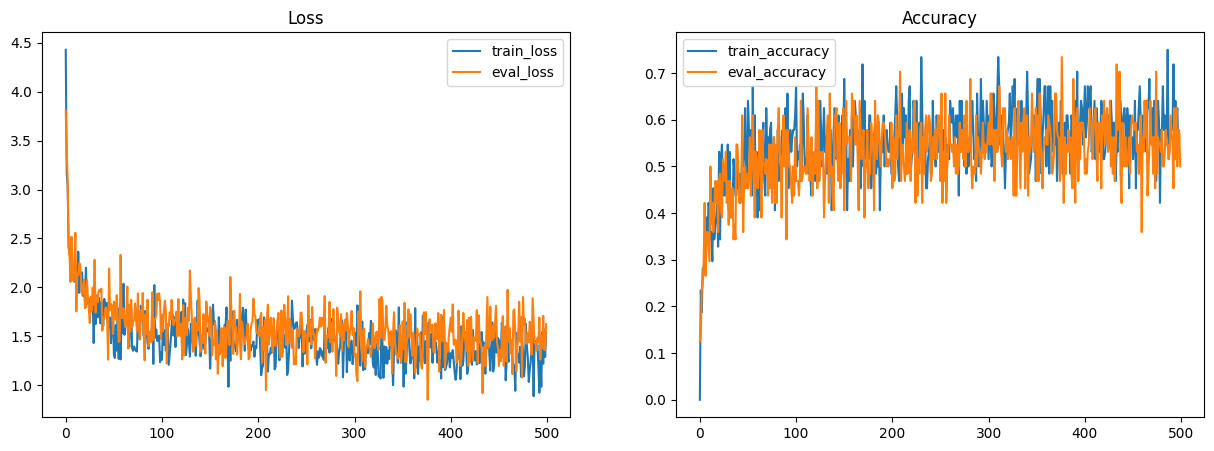

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [24]:
test_data[852:852+block_size]

Array([51,  6,  1, 53, 56,  1, 43, 50, 57, 43,  1, 63, 53, 59,  1, 42, 53,
        1, 51, 43,  1, 61, 56, 53, 52, 45, 10,  0, 20, 47, 57,  1],      dtype=int32)

In [25]:
i = 852
decode(test_data[i:i+block_size].tolist())

'm, or else you do me wrong:\nHis '

In [26]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(927))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
first_token_gen = generate_text(key, new_params, new_tokenz, start_text)[:, 0, 0].tolist()
print(first_token_gen)
print('\n')
print(decode(start_text.tolist()+first_token_gen))

[10, 0, 13, 52, 42, 1, 21, 1, 42, 47, 43, 1, 61, 47, 58, 46, 1, 58, 46, 39, 52, 1, 40, 43, 1, 41, 53, 51, 44, 53, 56, 58, 1, 43, 39, 41, 58, 47, 41, 43, 1, 40, 63, 1, 58, 46, 43, 1, 53, 52, 43, 2, 0, 20, 53, 52, 43, 57, 58, 1, 56, 59, 43, 6, 1, 43, 56, 43, 1, 58, 53, 5, 58, 1, 39, 56, 58, 1, 56, 47, 45, 46, 58, 1, 47, 52, 1, 44, 56, 43, 43, 0, 32, 46, 39, 58, 1, 61, 53, 59, 50, 42, 1, 54, 50, 43, 39, 57, 47, 52, 45, 1, 46, 39, 52, 42, 1, 61, 46, 43, 56, 43, 1, 63, 53, 59, 0, 14, 43, 57, 47, 42, 43, 57, 1, 58, 59, 51, 40, 50, 43, 1, 41, 39, 57, 58, 1, 53, 59, 58, 41, 46, 43, 57, 1, 54, 53, 50, 39, 56, 1, 41, 53, 60, 43, 56, 5, 42, 1, 53, 54, 8, 0, 0, 15, 27, 30, 21, 27, 24, 13, 26, 33, 31, 10, 0, 28, 39, 56, 47, 57, 41, 53, 59, 57, 43, 6, 1, 61, 46, 47, 41, 46, 1, 58, 56, 53, 59, 40, 50, 63, 1, 57, 53, 1, 57, 58, 56, 47, 41, 58, 1, 61, 47, 52, 58, 43, 56, 56, 47, 52, 45, 1, 44, 53, 56, 1, 51, 63, 1, 58, 56, 59, 58, 46, 57, 6, 0, 27, 56, 1, 51, 39, 52, 63, 1, 44, 39, 50, 57, 43, 1, 39, 4

In [36]:
base_loss

Array(0.7418884, dtype=float32)

In [27]:
params['params'].keys()

dict_keys(['Dense_0', 'Down_Conv_0', 'Down_Conv_1', 'Down_Conv_2', 'Down_Conv_3', 'Embed_0', 'Embed_1', 'RMSNorm_0', 'RMSNorm_1', 'RMSNorm_2', 'RMSNorm_3', 'RMSNorm_4', 'S6_Unet_0'])

In [28]:
params['params']['S6_Unet_0'].keys()

dict_keys(['A', 'B', 'C', 'D', 'delta'])

In [29]:
var_params = copy.deepcopy(params)

In [30]:
var_params['params']['S6_Unet_0']['A_'] = jnp.exp(params['params']['S6_Unet_0']['delta']*params['params']['S6_Unet_0']['A'])
var_params['params']['S6_Unet_0']['B_'] = params['params']['S6_Unet_0']['delta']*params['params']['S6_Unet_0']['B']

var_params['params']['S6_Unet_0'].pop('A')
var_params['params']['S6_Unet_0'].pop('B')
var_params['params']['S6_Unet_0'].keys()

dict_keys(['C', 'D', 'delta', 'A_', 'B_'])

In [31]:
params['params']['S6_Unet_0'].keys()

dict_keys(['A', 'B', 'C', 'D', 'delta'])

In [32]:
var_params['params']['S6_Unet_0'].keys()

dict_keys(['C', 'D', 'delta', 'A_', 'B_'])

In [33]:
for key in params['params']['S6_Unet_0'].keys():
    
    n_params = sum(p.size for p in jax.tree_util.tree_leaves(params['params']['S6_Unet_0'][key]))

    print(f"Total number of parameters in {key}: {n_params:_}")

Total number of parameters in A: 1_048_576
Total number of parameters in B: 1_048_576
Total number of parameters in C: 32_768
Total number of parameters in D: 2_048
Total number of parameters in delta: 65_536


In [34]:
sum(p.size for p in jax.tree_util.tree_leaves(params['params'])) - sum(p.size for p in jax.tree_util.tree_leaves(params['params']['S6_Unet_0']))

5306241

In [35]:
params['params']['S6_Unet_0']['Conv_2']['kernel'].shape

KeyError: 'Conv_2'

In [ ]:
optax.softmax_cross_entropy_with_integer_labels(logits=jnp.array([[0.0,0.0,100.0,0.0,0.0]]), labels=jnp.array([3])).mean()

In [ ]:
inputs = jax.random.normal(jax.random.PRNGKey(567), (1,8,4))
inputs

In [ ]:
class Connv1d(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        
        return nn.max_pool(x , window_shape=(4,), strides=(2,), padding='same')

In [ ]:
conv_model = Connv1d()

params = conv_model.init(jax.random.PRNGKey(415),inputs)

conv_model.apply(params, inputs)

In [ ]:
conv_model.apply(params, conv_model.apply(params, inputs))

In [ ]:
1000//128

In [ ]:
128*7

In [ ]:
2*3

In [ ]:
class LLM_Inference(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=(0,0,0,0):
        embeds = nn.RMSNorm()(nn.Embed(vocab_size, mamba_n_embd)(x) + nn.Embed(block_size, mamba_n_embd)(jnp.arange(block_size)))
    
      

#         D = 0.1*self.param('D', jax.random.normal, (1, 1, hidden_dim))

        
        # x.shape = (Ba, 1, hidden_dim, seq_size)


        x0 = Down_Conv(features=s6_n_embd, kernel_size=2, padding=1)(embeds)
        x0 = jnp.expand_dims(jnp.transpose(x0,(0,2,1)), axis=1)

        x1 = Down_Conv(features=s6_n_embd, kernel_size=4, padding=2)(embeds)
        x1 = jnp.expand_dims(jnp.transpose(x1,(0,2,1)), axis=1)

        x2 = Down_Conv(features=s6_n_embd, kernel_size=8, padding=4)(embeds)
        x2 = jnp.expand_dims(jnp.transpose(x2,(0,2,1)), axis=1)
        
        x3 = Down_Conv(features=s6_n_embd, kernel_size=16, padding=8)(embeds)
        x3 = jnp.expand_dims(jnp.transpose(x3,(0,2,1)), axis=1)
                 
        _, seq_size , hidden_dim = x0.shape
                 
        A_ = -1*self.param('A_', nn.initializers.ones, (1, n_latent_dim, hidden_dim, seq_size))
        B_ = 0.1*self.param('B_', nn.initializers.ones, (1, n_latent_dim, hidden_dim, seq_size))
        C = 0.09*self.param('C', jax.random.normal, (1, n_latent_dim, hidden_dim))
        delta = 0.05*self.param('delta', jax.random.normal, (1, 1, hidden_dim, seq_size))
                 
        x0, h0 = self.generate(nn.RMSNorm()(x1)x, A, B, C, D, delta, h0)
    

        x1, h1 = ssm_unet(nn.RMSNorm()(x1), h0)
        
        
        x2, h2 = ssm_unet(nn.RMSNorm()(x2), h1)
        
        
        x3, h3 = ssm_unet(nn.RMSNorm()(x3), h2)
        
        

        x = jax.nn.silu(x0) + jax.nn.silu(x1) + jax.nn.silu(x2) + jax.nn.silu(x3)
#         x = x + Mamba()(nn.RMSNorm()(x))
    
         # * jnp.concatenate([x[:,1:,:],jnp.ones((x.shape[0],1,x.shape[-1]))], axis=1)
        
        x = x + FeedForward()(nn.RMSNorm()(x))
        
        x = nn.Dense(mamba_n_embd)(nn.RMSNorm()(x))
        
        x = nn.Dense(vocab_size)(nn.RMSNorm()(x))
        
        return x, (h0,h1,h2,h3)
    
 
    def generate_context(self, x, a_, b_, C, D, delta, h=0):
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
#         _, N, D, S = a_.shape
#         indices = jnp.tril(jnp.ones((S-1,S-1))) 
#         indices = jnp.expand_dims(a_[...,1:],axis=4)*jnp.expand_dims(indices, axis=(0,1,2)) + jnp.expand_dims(jnp.triu(jnp.ones((S-1,S-1)),1), axis=(0,1,2))
#         indices = (jnp.concatenate((indices, jnp.ones((1,N,D,S-1,1))), axis=-1)).prod(axis=-2)
#         h = (indices*(b_*x)).sum(axis=-1)
        y = ((C * h).sum(1, keepdims=True))# + D*x[:,:,:,-1]

#         self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return y, h    

In [ ]:
key, subkey = jax.random.split(key)
asd = jax.random.normal(key, (2,1,4))
print(asd)
bsd = jax.random.normal(subkey, (2,1,4))
print(bsd)

jnp.concatenate([asd,bsd], axis=1)

In [40]:
chars[3]

'$'